In [3]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import torch
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##The Hounsfield Unit (HU)
The Hounsfield Unit (HU) is a standardized scale used in medical imaging, particularly in computed tomography (CT) scans, to quantify the radiodensity of tissues within the body. It was introduced by Sir Godfrey Hounsfield, the inventor of the CT scanner.

The Hounsfield Unit scale is a numerical scale where water has a value of 0 Hounsfield Units, and values are assigned to different tissues based on their relative radiodensity compared to water. For example, tissues that are denser than water (such as bone) will have positive Hounsfield Unit values, while less dense tissues (like air-filled spaces) will have negative values.

In [6]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        # The rescale slope and rescale intercept allow to transform the pixel values to HU
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)


# Load the scans in given folder path
def load_scan(patient_id):
    a = [f for f in os.listdir(f'{input_folder}/{patient_id}') if f[0] != '.'][0]
    b = [f for f in os.listdir(f'{input_folder}/{patient_id}/{a}') if f[0] != '.'][0]
    path = f'{input_folder}/{patient_id}/{a}/{b}'
    ls = [f'{path}/{f}' for f in os.listdir(f'{input_folder}/{patient_id}/{a}/{b}') if f[0] != '.']
    ls.sort()
    slices = [dicom.read_file(s) for s in ls]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

In [1]:
input_folder='/Volumes/TEST'
# input_folder='/Volumes/TEST'
# Loads the patients folder names (which are also the patient Ids)
patients = [f for f in os.listdir(input_folder) if f[0] != '.']
patients.sort()

In [ ]:
a = [f for f in os.listdir(f'{input_folder}/{patient_id}') if f[0] != '.'][0]
b = [f for f in os.listdir(f'{input_folder}/{patient_id}/{a}') if f[0] != '.'][0]
path = f'{input_folder}/{patient_id}/{a}/{b}'
ls = [f'{path}/{f}' for f in os.listdir(f'{input_folder}/{patient_id}/{a}/{b}') if f[0] != '.']
ls.sort()
ls

['/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-001.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-002.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-003.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-004.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-005.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-006.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-007.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-008.dcm',


In [4]:
# testing for 4 patient. Hide this code block when not testing in local machine
patients=['AMC-001','AMC-002','AMC-003','AMC-004']
patients.sort()
labels = np.array([1,0,0,0])
patients

['AMC-001', 'AMC-002', 'AMC-003', 'AMC-004']

In [7]:
stacked_x = []

for patient_id in patients:
    patient_slices = load_scan(patient_id) # Reads the dicom files
    stacked_slices_or = get_pixels_hu(patient_slices) # Convert to Hounsfield Unit
    stacked_slices = resize(stacked_slices_or, (350, 512, 512))
    stacked_x.append(torch.tensor(stacked_slices)) # Stacking the images to make a 4D tensor

stacked_x = np.array(torch.stack(stacked_x))
stacked_x.shape

(4, 350, 512, 512)

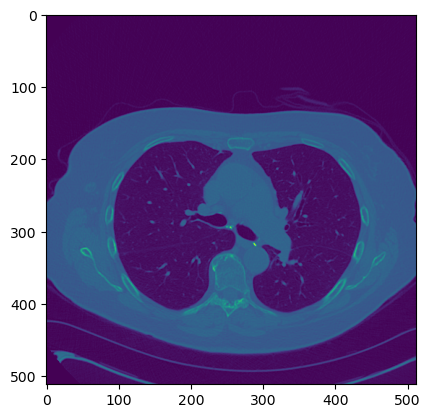

In [8]:
plt.imshow(stacked_x[3,200,:,:])

In [ ]:
f, axarr = plt.subplots(
        4,
        10,
        figsize=(18.0, 12.0),
        gridspec_kw={"height_ratios": [1,1,1,1]},
    )
a=100
for i in range(4):
        for j in range(10):
            print(f'i is {i} and j is {j}')
            axarr[i, j].imshow(stacked_x[0,a,:,:])
            a+=1
            axarr[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

In [3]:
df = pd.read_csv('labels.csv')
labels = np.array([1 if d == 'yes' else 0 for d in df['Recurrence']])
labels.shape

(211,)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(stacked_x, labels, test_size=0.25, random_state=0)

## Data Preprocessing (To be done)

## Data Loaders

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

## 3D Convolution Neural Network

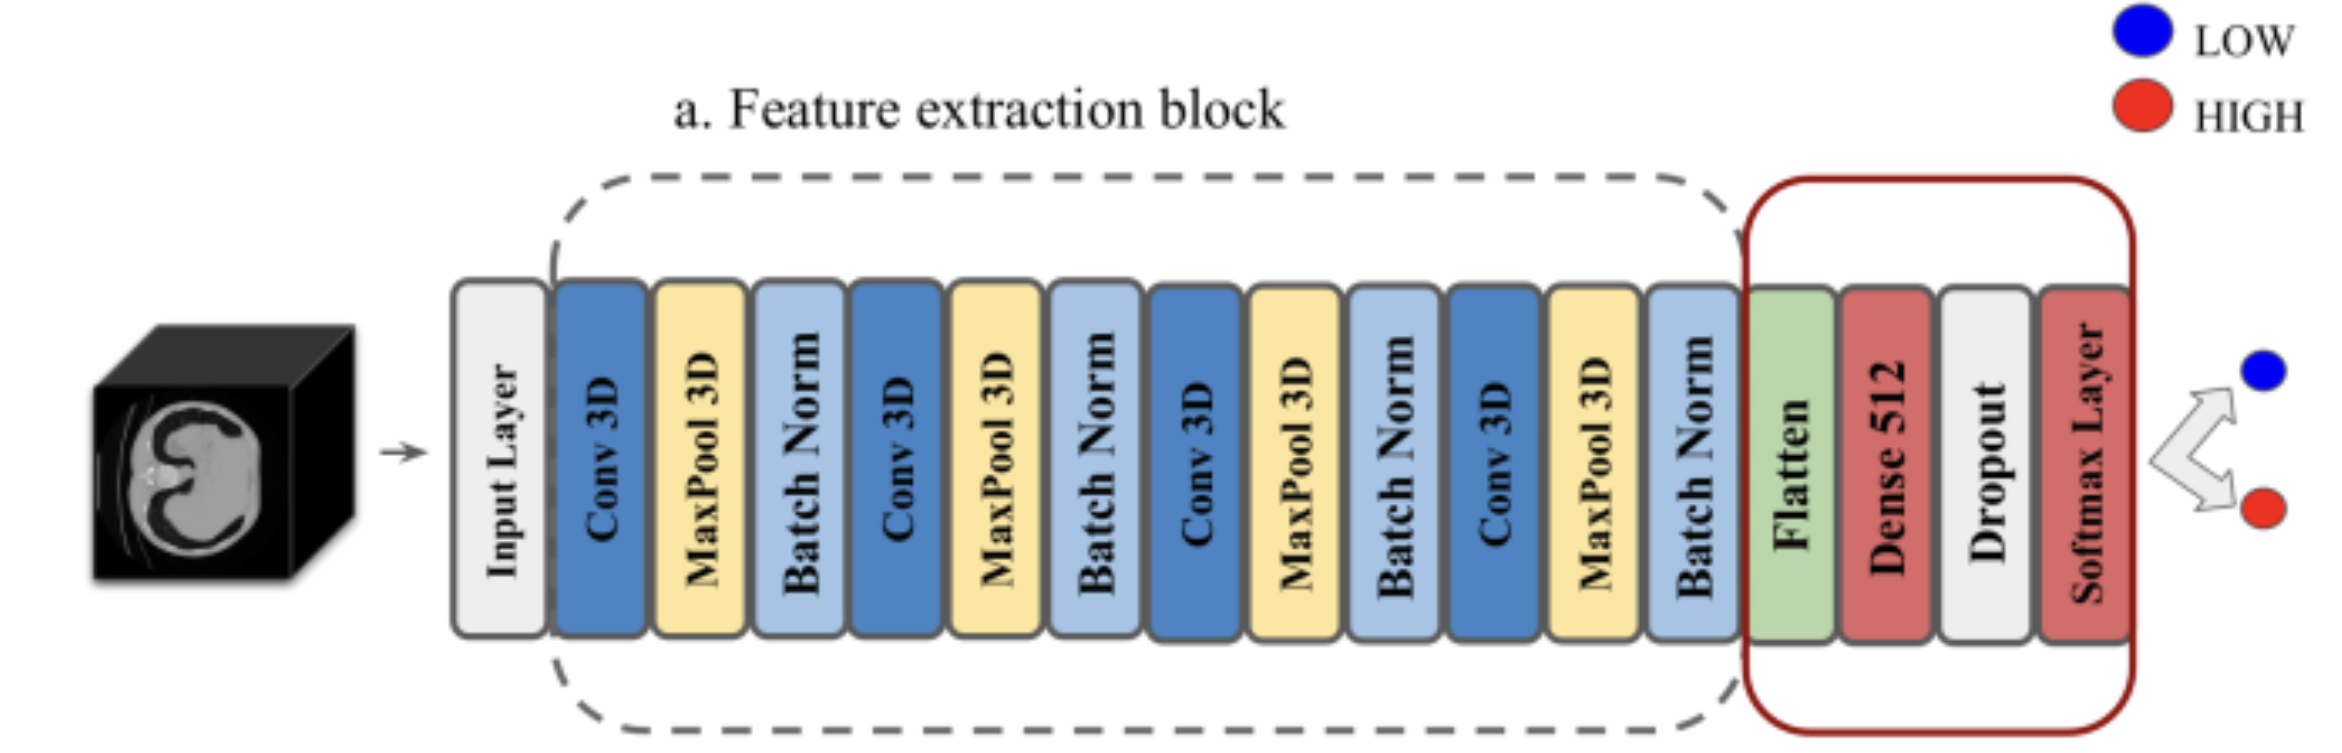


In [5]:
def my3DCNN(width=512, height=512, depth=350):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=350, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=350, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=1024, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=2048, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="tatzCNN")
    return model


# Build model.
model = my3DCNN(width=512, height=512, depth=350)
model.summary()

Model: "tatz3DCTCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 350,    0         
                             1)]                                 
                                                                 
 conv3d (Conv3D)             (None, 510, 510, 348, 3   9800      
                             50)                                 
                                                                 
 max_pooling3d (MaxPooling3  (None, 255, 255, 174, 3   0         
 D)                          50)                                 
                                                                 
 batch_normalization (Batch  (None, 255, 255, 174, 3   1400      
 Normalization)              50)                                 
                                                                 
 conv3d_1 (Conv3D)           (None, 253, 253, 172, 3   

## Training the Model

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "tatzCTCNN.h5", save_best_only=True
)
''' early stopping: if for 15 consecutive epochs the loss on the validation set does not improve, we stop the training process
     and restore the weights of the best model '''

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 1000
model.fit(
    train_loader,
    validation_data=validation_loader,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

## Reference Paper

Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction by Hasib Zunair, Aimon Rahman, Nabeel Mohammed, Joseph Paul Cohen.
https://arxiv.org/abs/2007.13224

The paper was published in the following book:

title={Uniformizing Techniques to Process CT Scans with 3D CNNs for Tuberculosis Prediction},

author={Zunair, Hasib and Rahman, Aimon and Mohammed, Nabeel and Cohen, Joseph Paul},

booktitle={International Workshop on PRedictive Intelligence In MEdicine},

pages={156--168},

year={2020},

organization={Springer} }